# CHAMPS Dataset Scalar Coupling

- Michael Follari
- [Predicting Molecular Properties](https://www.kaggle.com/c/champs-scalar-coupling)
- UNCG Physics 2020
- Dr. Ajay Covell

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model

More plot styling can be found [here.](https://matplotlib.org/tutorials/introductory/customizing.html)

In [60]:
plt.style.use('classic')

In [37]:
scalar_couple_df = pd.read_csv('D:\data\champs\zip\scalar_coupling_contributions.zip')
# champs_data = pd.read_csv('D:\data\champs\scalar_coupling_contributions.csv')

In [35]:
train_df = pd.read_csv('D:\data\champs\zip\\train.zip')

In [38]:
scalar_couple_df

,molecule_name,atom_index_0,atom_index_1,type,fc,sd,pso,dso
0,dsgdb9nsd_000001,1,0,1JHC,83.022400,0.254579,1.258620,0.272010
1,dsgdb9nsd_000001,1,2,2JHH,-11.034700,0.352978,2.858390,-3.433600
2,dsgdb9nsd_000001,1,3,2JHH,-11.032500,0.352944,2.858520,-3.433870
3,dsgdb9nsd_000001,1,4,2JHH,-11.031900,0.352934,2.858550,-3.433930
4,dsgdb9nsd_000001,2,0,1JHC,83.022200,0.254585,1.258610,0.272013
...,...,...,...,...,...,...,...,...
4659071,dsgdb9nsd_133884,17,4,2JHC,3.586440,0.019741,0.150477,-0.213205
4659072,dsgdb9nsd_133884,17,5,3JHC,0.674583,-0.007276,0.305078,-0.403388
4659073,dsgdb9nsd_133884,17,6,3JHC,1.337470,-0.028423,0.312240,-0.447920
4659074,dsgdb9nsd_133884,17,7,2JHC,4.800620,0.139202,-0.053102,-0.124710


In [39]:
train_df

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant
0,0,dsgdb9nsd_000001,1,0,1JHC,84.807600
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.257000
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.254800
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.254300
4,4,dsgdb9nsd_000001,2,0,1JHC,84.807400
...,...,...,...,...,...,...
4659071,4659071,dsgdb9nsd_133884,17,4,2JHC,3.543450
4659072,4659072,dsgdb9nsd_133884,17,5,3JHC,0.568997
4659073,4659073,dsgdb9nsd_133884,17,6,3JHC,1.173370
4659074,4659074,dsgdb9nsd_133884,17,7,2JHC,4.762010


### The different kinds of bonds present in the data

In [40]:
print( train_df.type.unique() )

['1JHC' '2JHH' '1JHN' '2JHN' '2JHC' '3JHH' '3JHC' '3JHN']


In [43]:
twojhh_df = train_df[ champs_df.type == '2JHH']

In [45]:
twojhh_df

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.257000
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.254800
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.254300
5,5,dsgdb9nsd_000001,2,3,2JHH,-11.254100
6,6,dsgdb9nsd_000001,2,4,2JHH,-11.254800
...,...,...,...,...,...,...
4658880,4658880,dsgdb9nsd_133882,9,10,2JHH,-7.875290
4658937,4658937,dsgdb9nsd_133883,9,10,2JHH,-0.753917
4658989,4658989,dsgdb9nsd_133883,15,16,2JHH,-8.667180
4659004,4659004,dsgdb9nsd_133884,9,10,2JHH,-0.833881


In [47]:
twojhh_df[['atom_index_0', 'scalar_coupling_constant']]

,atom_index_0,scalar_coupling_constant
1,1,-11.257000
2,1,-11.254800
3,1,-11.254300
5,2,-11.254100
6,2,-11.254800
...,...,...
4658880,9,-7.875290
4658937,9,-0.753917
4658989,15,-8.667180
4659004,9,-0.833881


# Linear Regression
- [Scikit Learn Linear Regression](https://scikit-learn.org/stable/modules/linear_model.html)

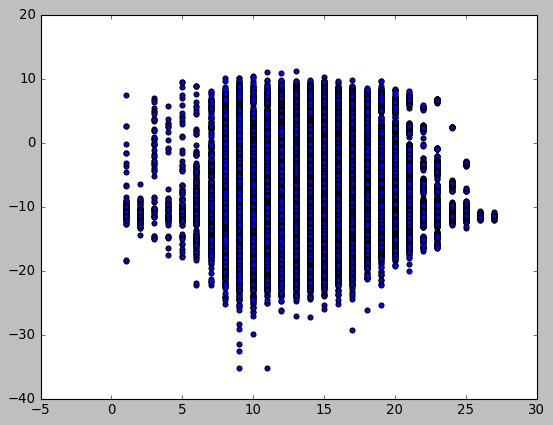

In [62]:
plt.scatter(twojhh_df['atom_index_0'], twojhh_df['scalar_coupling_constant'])

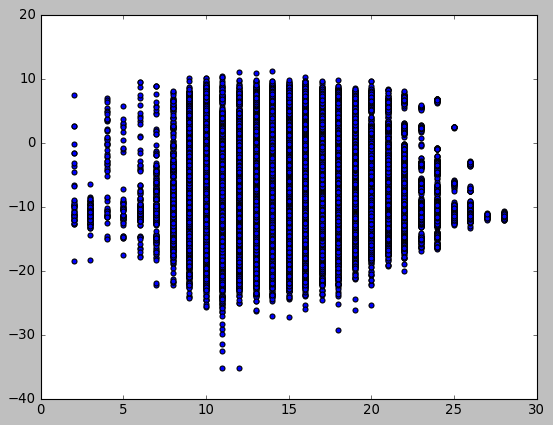

In [63]:
plt.scatter(twojhh_df['atom_index_1'], twojhh_df['scalar_coupling_constant'])